<a href="https://colab.research.google.com/github/Hrithik2212/Age-Estimation-and-Gender-Classification-CNN-/blob/main/00_Age_Gender_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age and gender Estimation 

In [1]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2 as cv
from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

## Data Wrangling 

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
def getFile_from_drive( file_id, name ):
 downloaded = drive.CreateFile({'id': file_id})
 downloaded.GetContentFile(name)
getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86',
 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-',
 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ',
 'fairface-label-val.csv')
!unzip -qq fairface-img-margin025-trainval.zip

## Data Exploration and Preparation

In [3]:
trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [4]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86744 entries, 0 to 86743
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file          86744 non-null  object
 1   age           86744 non-null  int64 
 2   gender        86744 non-null  object
 3   race          86744 non-null  object
 4   service_test  86744 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 2.7+ MB


## Model Building 

In [5]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
  def __init__(self,folder,tfms=None):
    self.df = folder 
    self.normalize = transforms.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])

  def __len__(self):
    return len(self.df)

  def __getitem__(self,ix):
    f = self.df.iloc[ix].squeeze()
    file = f.file
    gen = f.gender == 'Female'
    age = f.age
    im = cv.imread(file)
    im = cv.cvtColor(im,cv.COLOR_BGR2RGB)
    return im , age , gen 

  def process(self,im):
    im = cv.resize(im , (IMAGE_SIZE,IMAGE_SIZE))
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im/255.)
    return im[None] 

  def collate_fn(self,batch):
    '''preprocess image , gender and age''' 
    ims , ages , gens = [] , [] , [] 
    for im , age , gen in batch:
      im = self.process(im)
      ims.append(im)
      ages.append(float(int(age)/80))
      gens.append(float(gen))
    ages , gens =[torch.tensor(x).to(device).float() for x in [ages , gens]]
    ims = torch.cat(ims).to(device)
    return ims , ages ,gens 


In [6]:
train = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

In [7]:
train_loader = DataLoader(train , batch_size=32 ,shuffle=True ,collate_fn = train.collate_fn)
val_loader = DataLoader(val , batch_size=32 , collate_fn = val.collate_fn)
a , b , c = next(iter(train_loader))
a.shape , b.shape , c.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]), torch.Size([32]))

In [8]:
def get_model():
  model = models.vgg16(pretrained=True)
  for params in model.parameters():
    params.requires_grad=False
  model.avgpool = nn.Sequential(
                        nn.Conv2d(512,512,3),
                        nn.MaxPool2d(2),
                        nn.ReLU(),
                        nn.Flatten()
  )
  class GenderAgeClassifier(nn.Module):
    def __init__(self):
      super(GenderAgeClassifier,self).__init__()
      self.intermediate = nn.Sequential(
                          nn.Linear(2048,512),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(512,128),
                          nn.ReLU(),
                          nn.Dropout(0.4),
                          nn.Linear(128,64),
                          nn.ReLU(),
      )
      self.age_classifier = nn.Sequential(
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
      )
      self.gender_classifier = nn.Sequential(
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
      )
    def forward(self,X):
        x = self.intermediate(X)
        age = self.age_classifier(x)
        gen = self.gender_classifier(x)
        return age , gen 
    
  model.classifier = GenderAgeClassifier()
  gen_criterion = nn.BCELoss()
  age_criterion = nn.L1Loss()
  loss_fn = gen_criterion , age_criterion
  optim = torch.optim.Adam(model.parameters(),lr=1e-4)
  return model.to(device) , loss_fn , optim 

model , criterion , optimizer = get_model()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
from torchsummary import summary
summary(model , (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Model Training 

In [10]:
def train_batch(data,model,optimizer,criteria):
  model.train()
  ims , age, gender = data
  optimizer.zero_grad()
  pred_gender ,pred_age= model(ims)
  gender_criterion , age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(),gender)
  age_loss = age_criterion(pred_age.squeeze(),age)
  total_loss = age_loss + gender_loss
  total_loss.backward()
  optimizer.step()
  return total_loss

def validate_batch(data,model,criteria):
  model.eval()
  ims , age , gender = data
  with torch.no_grad():
    pred_gender , pred_age = model(ims)
  gender_criterion , age_criterion = criteria
  gender_loss = gender_criterion(pred_gender.squeeze(),gender)
  age_loss = age_criterion(pred_age.squeeze(),age)
  total_loss = age_loss + gender_loss
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()
  age_mae = torch.abs(age-pred_age).float().sum()
  return total_loss , gender_acc , age_mae

In [11]:
val_gender_accuracies ,val_age_maes = [] , []
train_losses , val_losses = [] , [] 

In [13]:
EPOCHS = 5
import time
best_test_loss = 1000
start = time.time()
for epoch in range(EPOCHS):
  epoch_train_loss , epoch_test_loss = 0 , 0 
  val_age_mae, val_gender_acc ,ctr = 0 , 0, 0
  _n = len(train_loader)
  for ix,data in enumerate(train_loader):
    loss = train_batch(data , model , optimizer , criterion)
    epoch_train_loss += loss.item()
  
  for ix , data in enumerate(val_loader):
    loss , gender_acc , age_mae = validate_batch(data,model,criterion)
    epoch_test_loss += loss
    val_age_mae += age_mae
    val_gender_acc += gender_acc
    ctr += len(data[0])

  val_age_mae /= ctr
  val_gender_acc /= ctr
  epoch_train_loss /= len(train_loader)
  epoch_test_loss /= len(val_loader)

  elapsed = time.time()-start
  best_test_loss = min(best_test_loss, epoch_test_loss)
  print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1,EPOCHS, time.time()-start, (EPOCHS-epoch)*(elapsed/(epoch+1))))
  info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
  info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
  print(info)

  val_gender_accuracies.append(val_gender_acc)
  val_age_maes.append(val_age_mae)


1/5 (680.44s - 3401.89s remaining)
Epoch: 001	Train Loss: 0.402	Test: 0.453	Best Test Loss: 0.4534
Gender Accuracy: 84.22%	Age MAE: 6.14

2/5 (1358.80s - 2717.49s remaining)
Epoch: 002	Train Loss: 0.288	Test: 0.502	Best Test Loss: 0.4534
Gender Accuracy: 84.45%	Age MAE: 6.26

3/5 (2052.57s - 2052.51s remaining)
Epoch: 003	Train Loss: 0.199	Test: 0.613	Best Test Loss: 0.4534
Gender Accuracy: 84.52%	Age MAE: 6.33

4/5 (2730.88s - 1365.41s remaining)
Epoch: 004	Train Loss: 0.157	Test: 0.721	Best Test Loss: 0.4534
Gender Accuracy: 84.28%	Age MAE: 6.43

5/5 (3409.01s - 681.79s remaining)
Epoch: 005	Train Loss: 0.139	Test: 0.800	Best Test Loss: 0.4534
Gender Accuracy: 83.02%	Age MAE: 6.39



In [26]:
val_age_maes = np.array([x.cpu().numpy() for x in val_age_maes])

## Model Evaluation

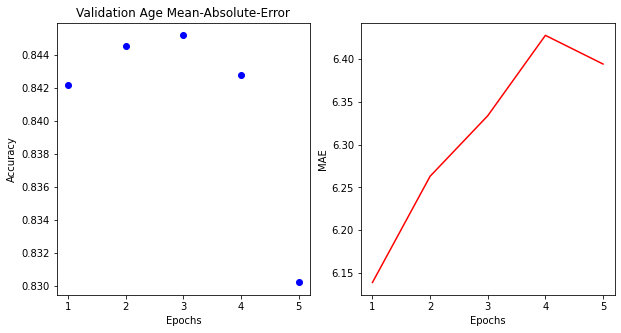

In [28]:
epochs = np.arange(1,(EPOCHS+1))
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, val_gender_accuracies, 'bo')
ax[1].plot(epochs, val_age_maes, 'r')
ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()

## Save Model 

In [29]:
torch.save(model.to('cpu').state_dict(), 'AgeEstimator&&GenderClassifierV0.pth')

## Testing Model on Images

In [31]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

predicted gender: Male ; Predicted age 75


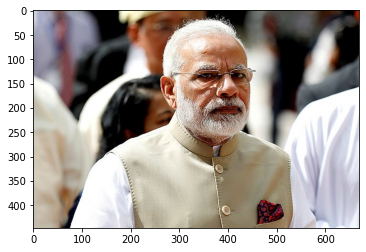

In [48]:
fpt ='/content/test_4.jpg'
img = cv.imread(fpt)
img = train.process(img).to(device)
age , gender = model(img)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
img = cv.imread(fpt)
img = cv.cvtColor(img , cv.COLOR_BGR2RGB )
plt.imshow(img)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'),'; Predicted age', int(pred_age[0][0]*80))

predicted gender: Female ; Predicted age 20


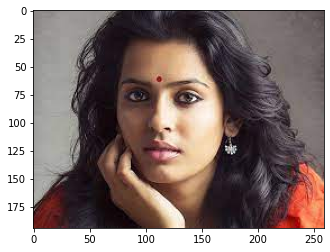

In [43]:
fpt ='/content/test_3.jfif'
img = cv.imread(fpt)
img = train.process(img).to(device)
gender , age = model(img)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
img = cv.imread(fpt)
img = cv.cvtColor(img , cv.COLOR_BGR2RGB )
plt.imshow(img)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'),'; Predicted age', int(pred_age[0][0]*80))